# Data analysis

Table of Contents
 
 * Clustering: k-means algorithm
 * Outliers detection: boxplots
 * Association-rule: apriori algorithm
 
## Clustering: k-means algorithm

In this tutorial we will use the k-means algorithm to cluster collections in ARTchives by their subject artistic periods. Specifically, we want to understand whether artistic periods (characterised by their earliest and latest dates) offer relevant insights with respect to the dates of the collections (earliest - latest dates), or vice-versa.

The k-means algorithm is used for exploratory purposes on data that are not categorised (i.e. we don't know yet what is the research question!), that means that the result of clustering must be interpreted and according to the characteristics of groupings the viewer decides how to label the groupings (if they make sense!).

We start from the basics and we parse ARTchives data into a RDFLibe graph.

In [1]:
import rdflib
from rdflib import Namespace , Literal , URIRef
from rdflib.namespace import RDF , RDFS

# bind the uncommon namespaces
wd = Namespace("http://www.wikidata.org/entity/") # remember that a prefix matches a URI until the last slash (or hashtag #)
wdt = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")

# create an empty Graph
g = rdflib.ConjunctiveGraph()

# parse a local RDF file by specifying the format
result = g.parse("../resources/artchives.nq", format='nquads')

Then we filter data to obtain a table where each row corresponds to a unique combination of `collection URI - collection earliest year - collection latest year - subject period URI - period earliest year - period latest year`. We use a SPARQL query on the graph.

In [2]:
query_coll_periods_dates = g.query("""
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX art: <https://w3id.org/artchives/>
SELECT DISTINCT ?coll ?coll_begin ?coll_end ?period ?period_begin ?period_end
WHERE {
 ?coll art:hasSubjectPeriod ?period ;
       wdt:P1319 ?coll_begin ; wdt:P1326 ?coll_end .
 ?period wdt:P580 ?period_begin ; wdt:P582 ?period_end .
}
""")

We transform the results of the query in a csv file.

In [3]:
import csv
with open('coll_periods_cluster.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['collection', 'collection_begin', 'collection_end', 'period', 'period_begin', 'period_end'])
    
    # access the rows of the query results
    for coll, coll_begin, coll_end, period, period_begin, period_end in query_coll_periods_dates:
        # write in the csv
        my_writer.writerow([coll, coll_begin[:4], coll_end[:4], period, period_begin[:4], period_end[:4]])

We parse the table (csv) into a pandas dataframe.

In [4]:
import pandas as pd
# parse the csv into a dataframe
data = pd.read_csv("coll_periods_cluster.csv")
# print the first 5 rows
data.head()

,collection,collection_begin,collection_end,period,period_begin,period_end
0,https://w3id.org/artchives/collectionjulius-s-...,1918,1999,http://www.wikidata.org/entity/Q7016,1601,1700
1,https://w3id.org/artchives/collectionfototeca-...,1965,2018,http://www.wikidata.org/entity/Q4692,1400,1650
2,https://w3id.org/artchives/collectionfototeca-...,1965,2018,http://www.wikidata.org/entity/Q7017,1501,1600
3,https://w3id.org/artchives/collectionnachlass-...,1937,1949,http://www.wikidata.org/entity/Q7017,1501,1600
4,https://w3id.org/artchives/collectionjohn-pope...,1617,1995,http://www.wikidata.org/entity/Q4692,1400,1650


To perform clustering we need only **numeric values**, therefore we prune from the dataframe the columns that include categorical data (the uris). We do this by *creating a copy of the dataframe* (i.e., we don't work on the original one).

**NB** Data frames index the rows with an index number (the first left column), hence at the end of the clustering, we can match the two dataframes and identify which collection and which period has been categorized in a cluster.

In [6]:
df = pd.DataFrame(data,columns=['collection_begin','collection_end','period_begin','period_end'])
df.head()

,collection_begin,collection_end,period_begin,period_end
0,1918,1999,1601,1700
1,1965,2018,1400,1650
2,1965,2018,1501,1600
3,1937,1949,1501,1600
4,1617,1995,1400,1650


To perform clustering using the k-means algorithm, we use the class *KMeans* offered by the python machine learning library **sklearn**. To plot the clusters we use another library for data visualization called **matplotlib** (that is the basic block of seaborn).

*KMeans* requires the user to choose the number of clusters to be created. Usually, you can try several attempts and see which one makes more sense (e.g. if clusters in the plot are not too sparse groupings, if the centroids of the clusters are somehow in the middle of the grouping).

For instance, we try to form 4 clusters. To start, we use only the beginning dates of both collections and artistic periods.

[[1964.125      2006.25       1773.5        1858.875     ]
 [1925.79411765 1987.5        1427.02941176 1592.64705882]
 [1930.4        1980.2         476.         1500.        ]
 [1941.70588235 1993.52941176 1595.17647059 1726.47058824]]


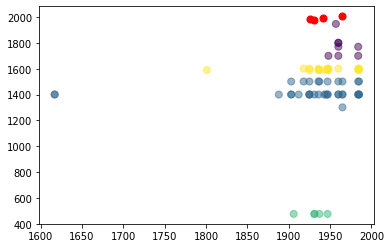

In [7]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

kmeans_attempt = KMeans(n_clusters=4).fit(df)
centroids = kmeans_attempt.cluster_centers_
print(centroids)

# we plot only beginning dates!
plt.scatter(df['collection_begin'], df['period_begin'],  c= kmeans_attempt.labels_.astype(int), s=50, alpha=0.5)
# plot the centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50) 
plt.show()

The red spots are the centers of the clusters, which do not really match any of the clusters.

To find the optimal number of clusters, we can use the **elbow method**. The elbow method runs k-means clustering on the dataset for a range of values for k (say from 1 to 10) and then for each value of k computes an average score for all clusters, so as to find the optimal one.

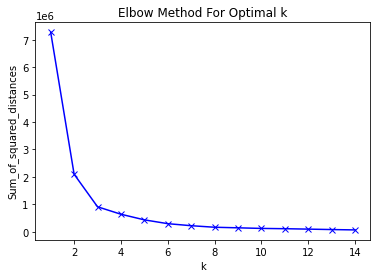

In [8]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df)
    # the average of the squared distances from the cluster centers of the respective clusters. 
    # Typically, is the Euclidean distance
    sum_of_squared_distances.append(km.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()    

When these metrics for each model are plotted, it is possible to visually determine the best value for k. If the line chart looks like an arm, then the “elbow” (the point of inflection on the curve) is the best value of k. The “arm” can be either up or down, but if there is a strong inflection point, it is a good indication that the underlying model fits best at that point. 

In our case the best value is 3 (read the x axis and get the point where the inflection is stronger). We can now recompute the clusters suggesting this number.

[[1925.79411765 1987.5        1427.02941176 1592.64705882]
 [1930.4        1980.2         476.         1500.        ]
 [1948.88       1997.6        1652.24       1768.84      ]]


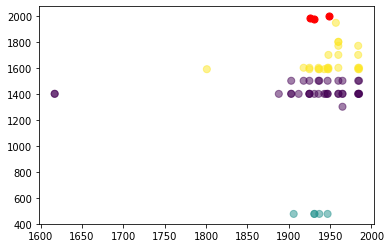

In [9]:
kmeans = KMeans(n_clusters=3).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(df['collection_begin'], df['period_begin'],  c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

Unfortunately, the result is not much different. This means two things:

 * the variables of the dataset (beginning of collections and beginning of artistic periods) are too independent and no cluster makes sense
 * the variables may be simplified or changed so as to understand if there is another reason for clustering
 
We try to simplify our table and, instead of four variables (columns), we use only two variables. For instance, we calculate the means (average) of earliest and latest dates (for both of the collection dates and the periods dates).

In [10]:
# we use a lambda function to add to the dataframe two columns with the means
df['collection_mean'] = df.apply(lambda row: (row.collection_begin + row.collection_end)/2, axis=1) # axis=1 stands for the index of columns 
df['period_mean'] = df.apply(lambda row: (row.period_begin + row.period_end)/2, axis=1)
df.head()

,collection_begin,collection_end,period_begin,period_end,collection_mean,period_mean
0,1918,1999,1601,1700,1958.5,1650.5
1,1965,2018,1400,1650,1991.5,1525.0
2,1965,2018,1501,1600,1991.5,1550.5
3,1937,1949,1501,1600,1943.0,1550.5
4,1617,1995,1400,1650,1806.0,1525.0


We extract the two new columns and we copy them in a new dataframe.

In [11]:
new_df = df[['collection_mean','period_mean']]
new_df.head()

,collection_mean,period_mean
0,1958.5,1650.5
1,1991.5,1525.0
2,1991.5,1550.5
3,1943.0,1550.5
4,1806.0,1525.0


Now we repeat prior steps. We calculate the optimal number of clusters with the elbow method.

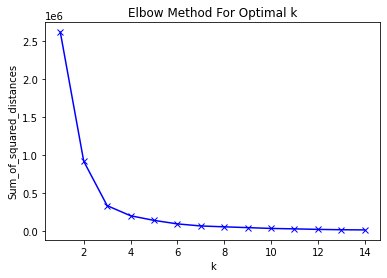

In [12]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(new_df) # on the new dataframe
    sum_of_squared_distances.append(km.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show() 

The optimal number of clusters seems to be 3. We apply the k-means algorithm to find the clusters and plot them in a visualization.

[[1956.64705882 1509.83823529]
 [1973.24       1710.54      ]
 [1955.3         988.        ]]


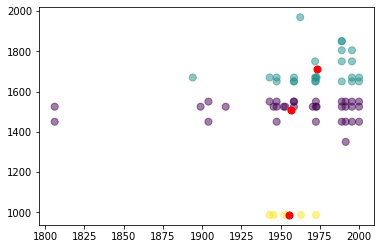

In [13]:
kmeans = KMeans(n_clusters=3).fit(new_df)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(df['collection_mean'], df['period_mean'],  c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

The result now is much better. Still, I'm not completely happy, because some clusters seem to be too sparse. I'll try with four.

[[1956.64705882 1509.83823529]
 [1955.3         988.        ]
 [1985.1875     1816.1875    ]
 [1967.61764706 1660.82352941]]


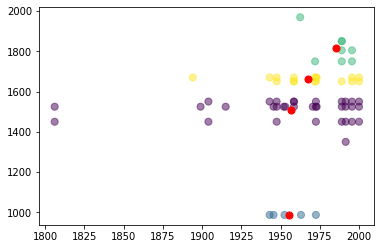

In [14]:
kmeans = KMeans(n_clusters=4).fit(new_df)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(df['collection_mean'], df['period_mean'],  c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

Now I can see a pattern in the result. We get four clusters that are quite neat with respect to the artistic periods (y axis), and slightly more sparse with respect to the collection years (x axis). 

However, we can already see some **patterns**. The bottom cluster includes collections created between '40s and '70s addressing artistic periods that have as an average year ~1000, that is Middle Age and antiquities.
The second cluster from the bottom includes collections created in a broad range, but with a center around the '50s-'60s, addressing artistic periods belonging to 15-16th centuries. Likewise, the third cluster from the bottom addresses the 17th century, and the top cluster addresses 18-20th centuries (showing us how this research topic is relatively more recent than others).

**NB** Be aware that in this visualization clusters include overlapping collections (i.e. a collection may belong to more clusters since it can address different artistic periods).

Now that we got this information we add it to our dataframe to store it and potentially reuse it in other contexts (e.g. for recommending collections to users on the basis of this classification). We create yet another dataframe and we use a built-in method of kmeans to extract the labels of the four clusters. We copy them into a new column, along with the names of the collections that we extract from the original dataframe.

In [17]:
# add the cluster name (a number) in the df
new_df2 = new_df.copy()
new_df2["cluster"] = kmeans.labels_
print(kmeans.labels_)
# give the clusters a more meaningful name 
new_df2["cluster"].replace({0:'17th century', 1: 'Middle age',2: '15-16th centuries',3: '18-20th centuries'}, inplace=True)
# which collections? 
new_df2["collection"] = data["collection"]

# Watch out! every time you rerun the clustering algorithm the names of clusters change! 
# Hence the labelling changes too (so if you see a mistake in the labelling it's because of that!)
new_df2.head(20)

[3 0 0 0 0 0 0 0 0 2 3 0 3 0 0 0 2 0 0 0 3 0 0 0 3 3 3 2 0 3 3 1 0 0 1 3 0
 0 0 3 0 0 1 0 3 1 3 3 2 0 0 3 2 3 2 0 0 2 3 0 2 0 1 0]


,collection_mean,period_mean,cluster,collection
0,1958.5,1650.5,18-20th centuries,https://w3id.org/artchives/collectionjulius-s-...
1,1991.5,1525.0,17th century,https://w3id.org/artchives/collectionfototeca-...
2,1991.5,1550.5,17th century,https://w3id.org/artchives/collectionfototeca-...
3,1943.0,1550.5,17th century,https://w3id.org/artchives/collectionnachlass-...
4,1806.0,1525.0,17th century,https://w3id.org/artchives/collectionjohn-pope...
5,1952.0,1525.0,17th century,https://w3id.org/artchives/collectionnachlass-...
6,1958.5,1525.0,17th century,https://w3id.org/artchives/collectionnachlass-...
7,1958.5,1550.5,17th century,https://w3id.org/artchives/collectionnachlass-...
8,1947.5,1525.0,17th century,https://w3id.org/artchives/collectionnachlass-...
9,1995.5,1750.0,15-16th centuries,https://w3id.org/artchives/collectionfototeca-...


Now we plot again the clusters by using a seaborn function and get more insights.

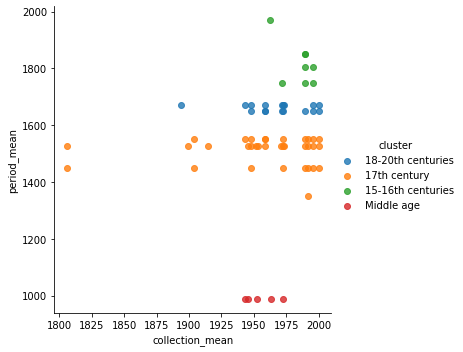

In [18]:
import seaborn as sns
# see documentation https://seaborn.pydata.org/generated/seaborn.lmplot.html
facet = sns.lmplot(data=new_df2, x='collection_mean', y='period_mean', hue='cluster', 
                   fit_reg=False, legend=True, legend_out=True)

# remember! the labels may be wrong because of the non deterministic nature of the algorithm

Seaborn allows us to fit **regression models** in the visualization. Regression is a way to model the relationship between a dependent variable and one or more independent variables. The case of one independent variable is called **simple linear regression**. To do that, we set the parameter `fit_reg` of our function `lmplot` to `True`.

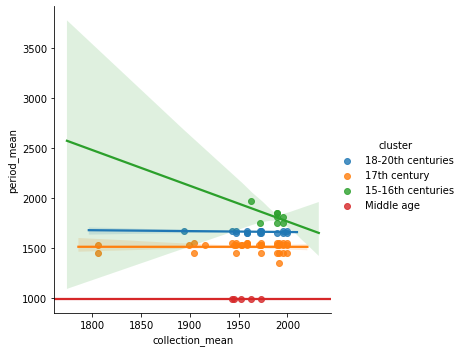

In [19]:
import seaborn as sns
facet = sns.lmplot(data=new_df2, x='collection_mean', y='period_mean', hue='cluster', 
                   fit_reg=True, legend=True, legend_out=True)

In our case, the linear regression can be useful to **predict** future topics of interest. For instance, look at the top cluster. It seems that in studies about 18-20th centuries there is a trend in rediscoverying past periods, that is: while the years of the collections on the x axis increase, and the number of collections increase, the years characterising the artistic periods decrease.

While we had a look on specific trends in clusters, we may want to have a general overview of future topics (periods) of interest by looking at the regression on the whole dataset. We use the `regplot` and `jointplot` functions and we see what happens.

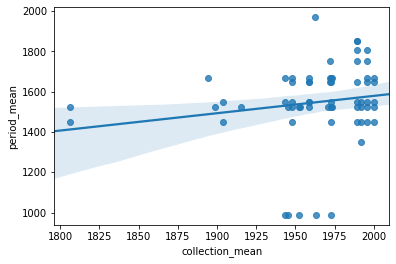

In [20]:
sns.regplot(x="collection_mean", y="period_mean", data=new_df2);

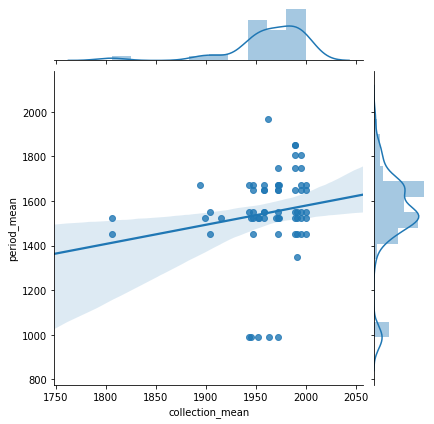

In [21]:
sns.jointplot(x="collection_mean", y="period_mean", data=new_df2, kind="reg"); # to see the distribution along with the regression

It seems the trend is quite stable with a slight inclination to dismiss studies on the 15th century and move towards 16th century.

### How is this interesting to anybody?

As we said, visualization is meant to support decision-making processes. But of whom? For instance, thanks to the renewed interest in art from the 18th century:

 * a historian may assume that in the near future there might be more fundings on projects addressing artistic periods falling in that timespan, and may try to apply for a grant on this topic
 * an art dealer may want to rise the price of artefacts that were created in that timespan
 * auction firms may want sell out more pieces from this period to collectionists
 * cataloguers may understand that other institutes are working on such topics, by collecting materials from that period, and they may want to do the same. 
 * cultural institutions (e.g. museums) may decide to create an exhibition to engage with experts and citizens on these *trendy* topics
 
No need to say, that this visualisation is based on a very few data, so currently **it is not very reliable**. But it's a start.

## Outliers detection: boxplots

To better understand how the linear regression (or any other model) fits the case study, we can have a look at the outliers in the datasets. Outliers are those data points that do not fit in the distribution. 
We use a **box plot** to explore our data and show the variance between quartiles (the two rectangular shapes inside the larger shape), where is the middle value of the dataset (the horizontal line inside the rectangular shape), the lowest and larger data points (the top and bottom horizontal lines) and the outliers (the data points that are beyond the whiskers). 

We use a function of seaborn called `boxplot` to understand the distribution of (average) years that we have in our datasets.

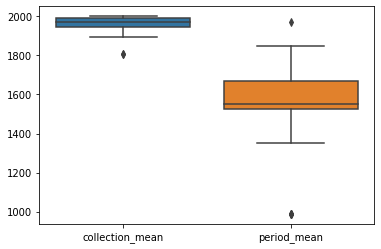

In [23]:
# use Boxplots
# see documentation https://seaborn.pydata.org/generated/seaborn.boxplot.html
ax = sns.boxplot(data=new_df2)

We can get a better detail by using a **swarm plot**, which resembles the shape of the boxplot, but it gives more insights on the actual number of data points that are outliers.

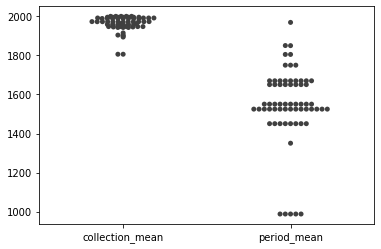

In [24]:
ax = sns.swarmplot(data=new_df2, color=".25")

We can then retrieve the values of the outliers. For instance, to see the outliers of artistic periods we do as follows:

In [25]:
from matplotlib.cbook import boxplot_stats
outliers = [y for stat in boxplot_stats(df['period_mean']) for y in stat['fliers']]
print(outliers)

[988.0, 988.0, 988.0, 988.0, 988.0, 1969.0]


We see that the outliers of ARTchives collections are artistic periods whose middle year falls around 988 (i.e. Middle age) and 1969 (i.e. Cold War). 

### How does this help me?

Outliers may hamper results of analysis. You may want to remove those from your data so that the analysis focuses on data that are more consistent. 

Or vice-versa, you may want to understand why these data points are outliers (is that because nobody is interested in these topics?), and may suggest cataloguers what is not covered in the current ARTchives catalogue. You may look in external datasets and find that there are collections relevant to those periods that can be included in ARTchives.

## Association-rule mining: apriori algorithm

In this tutorial we use the apriori algorithm to understand what is the likelihood that two or more artistic periods are studied together.

To work on co-occurrence of periods as subject of collections, we need to create a bespoke dataset that will fit the requirements of a function for computing the association rules. 

In particular, we need **a list of lists**, wherein each list includes all periods addressed by *one collection*. Be aware that the lists will not have the same length.

This time, to create our list of lists, we use RDFLib methods and we iterate over triples.

In [27]:
colls_and_periods = []

# get all the collections
for coll,isA,coll_class in g.triples(( None, RDF.type , wd.Q9388534)): 
    # create a list for each collection
    coll_list = [] 
    # get all the periods for that collection
    for this_coll, hasSubj, period in g.triples(( coll, art.hasSubjectPeriod, None)): 
        # get the labels of the periods
        for this_period, hasLabel, period_label in g.triples((period , RDFS.label, None )):
            # get only the last label
            period_label = str(period_label).strip() 
        # append periods to the related collection
        coll_list.append(period_label)
    # append collections to the initial list
    colls_and_periods.append(coll_list)
    
print(colls_and_periods)

[['Renaissance', '16th century', '15th century', '14th century'], ['Cold War'], ['Renaissance'], ['16th century', '15th century'], ['Renaissance', 'Baroque', '16th century', '17th century'], ['Baroque', '16th century', 'mannerism', 'Middle Ages'], ['15th century', 'Renaissance'], ['Baroque', 'mannerism'], [], ['Renaissance', '16th century', 'Baroque', '17th century', 'neoclassicism', '18th century', '15th century'], ['mannerism', 'Renaissance', 'Baroque', '16th century', '17th century', '15th century'], ['Renaissance'], ['15th century', 'mannerism', 'Renaissance', '16th century', 'Baroque', '17th century'], [], ['19th century', 'Renaissance', '16th century', '17th century', 'Romanticism', 'neoclassicism', '18th century', '15th century'], ['Renaissance', 'modern art'], ['Baroque', '18th century', '17th century'], ['Middle Ages'], ['Renaissance'], ['Renaissance'], ['16th century', '17th century'], ['early Christian art and architecture', 'Baroque', 'Renaissance', 'Byzantine art'], ['Rena

Now that we have our list of lists we use methods from a library called **mlxtend** to compute the frequent itemsets (i.e. the frequent co-occurring periods). The **apriori** algorithm is used and returns a table with two columns, namely:
 
 * itemsets, the co-occurring items (or independent items)
 * their support, normalised between 0 and 1, indicating the frequency of the co-occurrence in the dataset. 

In [28]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

dataset = colls_and_periods

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df, min_support=0.2, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.32,(15th century)
1,0.40,(16th century)
2,0.32,(17th century)
3,0.36,(Baroque)
4,0.20,(Middle Ages)
5,0.60,(Renaissance)
6,0.20,(mannerism)
7,0.28,"(16th century, 15th century)"
8,0.20,"(15th century, 17th century)"
9,0.28,"(15th century, Renaissance)"


The dataset is quite small and diverse, hence the co-occurrences do not have high support, meaning that the variables we are investigating **may be** independent from each other.

However, support is not the only metric of interest. The method `association_rules` allows us to specify another metric of interest and the threshold. The library supports **confidence** and **lift** (See more [here](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/)). 

For instance, let's have a look at the itemsets that have high confidence, regardless of their support. That is, let's see which are the rules where the probability of seeing the consequent in a transaction (given a certain antecedent) is almost sure (0.9 out of 1).

In [29]:
from mlxtend.frequent_patterns import association_rules
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.9)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(mannerism),(Baroque),0.20,0.36,0.20,1.0,2.777778,0.128,inf
1,"(15th century, 17th century)",(16th century),0.20,0.40,0.20,1.0,2.500000,0.120,inf
2,"(15th century, 17th century)",(Renaissance),0.20,0.60,0.20,1.0,1.666667,0.080,inf
3,"(Renaissance, 17th century)",(16th century),0.24,0.40,0.24,1.0,2.500000,0.144,inf
4,"(16th century, 15th century, 17th century)",(Renaissance),0.20,0.60,0.20,1.0,1.666667,0.080,inf
5,"(15th century, Renaissance, 17th century)",(16th century),0.20,0.40,0.20,1.0,2.500000,0.120,inf
6,"(15th century, 17th century)","(16th century, Renaissance)",0.20,0.28,0.20,1.0,3.571429,0.144,inf
7,"(16th century, Renaissance, Baroque)",(17th century),0.20,0.32,0.20,1.0,3.125000,0.136,inf
8,"(16th century, Baroque, 17th century)",(Renaissance),0.20,0.60,0.20,1.0,1.666667,0.080,inf
9,"(Renaissance, Baroque, 17th century)",(16th century),0.20,0.40,0.20,1.0,2.500000,0.120,inf


Since we selected a very high threshold, we see that all the rules have a perfect confidence (`1.0`), despite a low support (again, we have few and diverse data), high lift (how much often antec and conseq appear together, the higher the more these are dependent), and high conviction (`inf` means that the consequent is highly depending on the antecedent). 

From the results we get some interesting insights. For instance, it seems very likely that mannerism and baroque are studied together. Similarly, if a collection addresses 15th century and 17th century, it's very likely that it will also address Renaissance and 16th century. 

### Why is this interesting?

Assume that *cataloguers of ARTchives did not enter data with the same effort* for every collections. Some collections may be more accurately annotated, while others might include just a few topics.

We can quantify the probability to find certain topics that are not explictly stated by cataloguers and we can recommend collections to historians according to the relevance of these probabilities. For instance, if a user is looking for collections relevant to *Baroque*, we may rank collections, showing first the ones that address for sure the searched term, and secondly the ones that are *more likely* to address it, i.e. those addressing *Mannerism*.

## Exercise / Homework

Apply the apriori algorithm to calculate which people (`art:hasSubjectPerson`) mostly co-occur in ARTchives collections. Write the three rules with the highest confidence in the form: (antecedents) - (consequents).
Fill in the [questionnaire](https://forms.gle/cri2JhzGTzGzofZu7) with the answer!